In [1]:
import sys
sys.path.append("../mypkg")

In [81]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from scipy.stats import pearsonr

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat

plt.style.use('ggplot')
plt.rcParams["savefig.bbox"] = "tight"

In [43]:
from utils.misc import save_pkl, load_pkl
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse

## Parameters and fns

### Params

In [6]:
_paras = edict()
_paras.res_dir = RES_ROOT/"linear_1"

In [9]:
paras = load_pkl(_paras.res_dir/"paras.pkl")
paras.keys()

dict_keys(['model', 'num_rep', 'ns', 'npts', 'd', 'q', 'sigma2', 'sel_idx', 'stop_cv', 'max_iter', 'can_lams', 'can_Rfcts', 'bsp', 'types_', 'alp_GT', 'Gam_GT', 'Rmin', 'basis_mat', 'save_dir'])

In [ ]:
paras.ns = [100, 200, 400, 800, 1600, 3200]

### Fn

In [20]:
def _filename2paras(p):
    """Get the parameters (lam, Rfct, n) based on filename
    """
    sep_p = p.stem.split("_")
    assert sep_p[1].startswith("lam")
    assert sep_p[2].startswith("Rfct")
    assert sep_p[3].startswith("n")
    lam_v = int(sep_p[1].split("-")[-1])/100
    Rfct_v = int(sep_p[2].split("-")[-1])/10
    n_v = int(sep_p[3].split("-")[-1])
    res = edict()
    res.lam = lam_v
    res.Rfct = Rfct_v
    res.n = n_v
    return res

In [137]:
def _res2err(opt, paras):
    """The fn to return the error"""
    errs = edict()
    alp_est = opt.thetak[:paras.q].numpy()
    gam_est = opt.Gamk.numpy()
    gamN_diff = col_vec_fn(gam_est - paras.Gam_GT)/np.sqrt(paras.bsp.N)
    alp_diff = alp_est - paras.alp_GT
    
    gam_est_l0 = np.linalg.norm(gam_est, axis=0)[paras.sel_idx] == 0
    gam_gt_l0 = np.linalg.norm(paras.Gam_GT, axis=0)[paras.sel_idx] == 0
    errs.gam_err_l0 = np.bitwise_xor(gam_est_l0, gam_gt_l0).sum()
    errs.gam_err_l0_neg = (gam_gt_l0.astype(int) -  gam_est_l0.astype(int))[np.bitwise_not(gam_gt_l0)].sum()
    
    errs.gam_err_l1 = np.abs(gamN_diff).sum()
    errs.gam_err_l2 = np.linalg.norm(gamN_diff)
    
    errs.alp_err_l1 = np.abs(alp_diff).sum()
    errs.alp_err_l2 = np.linalg.norm(alp_diff)
    
    errs.overall_l1 = errs.gam_err_l1 + errs.alp_err_l1
    errs.overall_l2 = np.sqrt(errs.gam_err_l2**2 + errs.alp_err_l2**2)
    return errs

## Load data

## Analysis

In [148]:
cur_n = 3200
fils = list(_paras.res_dir.glob(f"result_*n-{cur_n}*.pkl"))
sorted_fils = sorted(fils, key=lambda x: _filename2paras(x).lam*100+_filename2paras(x).Rfct*1)

In [149]:
# load file first to save time
resss = []
for cur_fil in tqdm(sorted_fils):
    ress = load_pkl(cur_fil)
    resss.append(ress)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [07:35<00:00, 18.22s/it]


In [195]:
err_mat = np.zeros((len(paras.can_lams), len(paras.can_Rfcts)))
for ix, cur_fil in enumerate(sorted_fils):
    cur_para = _filename2paras(cur_fil)
    
    row_idx = paras.can_lams.index(cur_para.lam)
    col_idx = paras.can_Rfcts.index(cur_para.Rfct)
    
    
    ress = resss[ix]
    errs = []
    for cur_res in ress:
        cur_res = cur_res[0]
        if not cur_res[-1]:
            err =_res2err(cur_res[0], paras)
            errs.append(err)
            
    sel_err = np.mean([err.overall_l2 for err in errs])
    err_mat[row_idx, col_idx] = sel_err

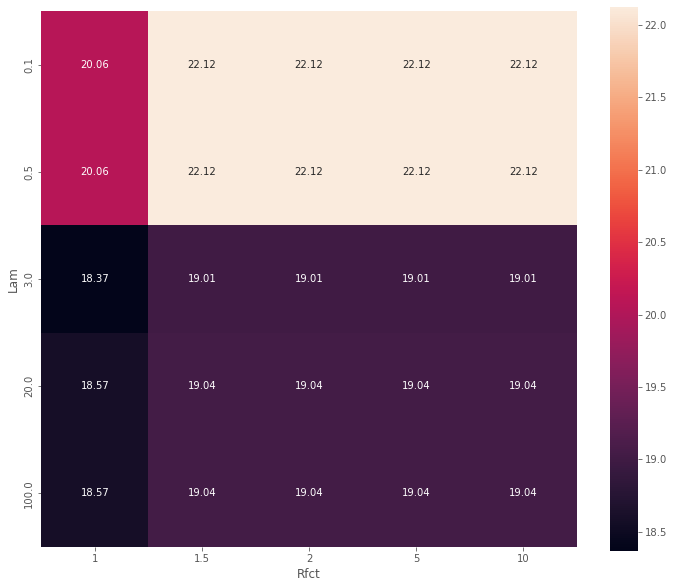

In [196]:
plt.figure(figsize=[12, 10])
sns.heatmap(err_mat, annot=np.round(err_mat, 3), square=1, fmt=".2f")
plt.xlabel("Rfct")
plt.ylabel("Lam")
plt.xticks(np.arange(len(paras.can_Rfcts))+0.5, paras.can_Rfcts)
plt.yticks(np.arange(len(paras.can_lams))+0.5, paras.can_lams);

In [182]:
err_mat

array([[0.2293361 , 0.23384581, 0.23384581, 0.23384581, 0.23384581],
       [0.2293361 , 0.23384581, 0.23384581, 0.23384581, 0.23384581],
       [0.71564381, 0.687032  , 0.687032  , 0.687032  , 0.687032  ],
       [0.74268175, 0.7443916 , 0.7443916 , 0.7443916 , 0.7443916 ],
       [0.74268175, 0.7443916 , 0.7443916 , 0.7443916 , 0.7443916 ]])